# M.5. Solutions

## Markets Foundations

### UChicago Financial Mathematics

#### September 2022

* Mark Hendricks
* hendricks@uchicago.edu

#### This assignment is not submitted, graded, or for credit. 
Rather, it is assigned for learning purposes.

## 1 Calculating Returns

Use the data in `data/equity_data.xlsx`
* tab `prices AAPL`: columns `Unadjusted Price` and `Adjusted Price`
* tab  `dividends AAPL`: columns `ex_date` and `dividend_amount`

### 1.1
For the most recent 2 dividend dates, calculate the one-day return to AAPL using the unadjusted price and the dividend amount. 

That is, for a given dividend, calculate the return for the day prior to the "ex date" and ending on the "ex date". Do this for at least the most recent two dividends. (Though it is probably just as easy to adjust the return on every dividend date.)

How close is this to the return calculated from the adjusted price percentage change?

### 1.2
For the most recent stock split, (see multiple in `dividend_amount` and indicated in the column `dividend_type`,) calculate the return to AAPL using the unadjusted price along with this split and dividend info.

How close is this computed return to that calculated from the adjusted price growth?

## 2 Stock Sensitivity

Use the data in `data/equity_data.xlsx`, in the tab `etf history`.

For the ETFs listed in `etf history`, calculate their percentage change over time. (These are adjusted prices, so this is a measure of their returns.)

## 2.1
Report the correlation table.

## 2.2

### Background
Recall that in analyzing fixed income products, duration measures the percentage change of price with respect to a shift in rates:

$$\frac{dP}{P} = -D dr + \epsilon$$

This concept is duration is at the heart of much of the trading in fixed income.

In equities, there is an analogous concept: a stock's **beta**:

$$r_t = \alpha + \beta r^{\text{SPY}}_t + \epsilon_t$$

This beta is analyzed with respect to many factors, but it is most widely analyzed with respect to the S&P 500 (or a similar, broad equity index. Thus the notation $r^{\text{SPY}}_t$ on the right-hand side.

### Calculation
For each ETF return series, estimate the regression above. (You will estimate many regressions, in a loop, each using SPY as the right-hand-side factor.)

Report these betas. Which ETF has the most overall stock-market risk?

#### Hint: 

To estimate the regression, consider using the following approach:

`from sklearn.linear_model import LinearRegression`

`LinearRegression().fit(X,y).coef_`

***

## 3 Factor Structure of Stocks

Why is the "market" (often meaning S&P500) beta so popular as a risk factor for equities? It is because, (like fixed income with rates,) there is a strong factor structure. That is, many stocks have a lot of correlation to the S&P 500.

To see this factor structure statistically, use `spx_returns_weekly.xlsx`, to do a principal component analysis (PCA) of S&P 500 returns.

### 3.1 
Calculate the variance explained by each PCA factor. List the top 5. How important is the first factor in explaining everything? Are the other factors important?

#### Hint

If the returns are in a pandas dataframe, `rets`, try using

`from sklearn.decomposition import PCA`

`pca = PCA(svd_solver='full')`

`pca.fit(rets)`

`pca.explained_variance_ratio_[0:5]`

### 3.2

Calculate the weights of the first PCA factor.
* Calculate the PCA loadings
* Normalize them to sum to 1

Make a bar chart of these (451!) weights.

How would you describe this factor? For instance, is it long-only? Is it long-short many securities?

Do the same for the second factor. How would you describe it?

#### Hint
The first row of `pca.components_` is what you need.


### 3.3
How similar is the first PC to SPY? 

1. Load SPY returns from `equity_data.xlsx`, tab `etf history`. Resample SPY into weekly returns.

2. Use the weights for the first PC factor and multiply them by the securities to get the timeseries of PC 1 factor returns.

3. Compare the (weekly-Friday) PC factor returns with the (weekly-Friday) SPY returns.

What is the correlation between them?

#### Hint
Try `spy.resample('W-Friday').last().pct_change()` if `spy` is the pandas dataframe with spy prices.

***

# <span style="color:red">Solutions</span>

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from portfolio import *

## <span style="color:red">Solution 1</span>

In [2]:
LOADFILE = '../data/equity_data.xlsx'
TICK = 'AAPL'
TAB = f'prices {TICK}'
px = pd.read_excel(LOADFILE,sheet_name=TAB).set_index('date')

TAB = f'dividends {TICK}'
dvds = pd.read_excel(LOADFILE,sheet_name=TAB).set_index('ex_date')
dvds

,record_date,declared_date,payable_date,dividend_amount,dividend_frequency,dividend_type
ex_date,,,,,,
2022-05-06,2022-05-09,2022-04-28,2022-05-12,0.230000,Quarter,Regular Cash
2022-02-04,2022-02-07,2022-01-27,2022-02-10,0.220000,Quarter,Regular Cash
2021-11-05,2021-11-08,2021-10-28,2021-11-11,0.220000,Quarter,Regular Cash
2021-08-06,2021-08-09,2021-07-27,2021-08-12,0.220000,Quarter,Regular Cash
2021-05-07,2021-05-10,2021-04-28,2021-05-13,0.220000,Quarter,Regular Cash
...,...,...,...,...,...,...
1988-02-12,1988-02-19,1988-01-28,1988-03-15,0.000714,Quarter,Regular Cash
1987-11-17,1987-11-23,1987-11-12,1987-12-15,0.000714,Quarter,Regular Cash
1987-08-10,1987-08-14,1987-07-31,1987-09-15,0.000536,Quarter,Regular Cash


### 1.1

With the adjustments, returns are identical up to 4 decimal places.

In [3]:
rets = px.pct_change()
rets['Unadjusted Price Modified'] = rets.copy()['Unadjusted Price']

for dt in dvds.index:
    if dt in rets.index:
        if dvds.loc[dt,'dividend_type']=='Regular Cash':
            rets.loc[dt,'Unadjusted Price Modified'] = (px.loc[dt,'Unadjusted Price'] + dvds.loc[dt,'dividend_amount']) / px['Unadjusted Price'].shift().loc[dt] - 1

        elif dvds.loc[dt,'dividend_type']=='Stock Split':
            rets.loc[dt,'Unadjusted Price Modified'] = dvds.loc[dt,'dividend_amount'] * px.loc[dt,'Unadjusted Price'] / px['Unadjusted Price'].shift().loc[dt] - 1

In [4]:
rets.loc[dvds.index[0:2],:].style.format('{:.4%}')

,Adjusted Price,Unadjusted Price,Unadjusted Price Modified
ex_date,,,
2022-05-06 00:00:00,0.4727%,0.3253%,0.4720%
2022-02-04 00:00:00,-0.1682%,-0.2950%,-0.1677%


### 1.2

By adjusting for the split, we get almost the exact same return as the "Adjusted Price" series.

Note that the "Unadjusted Price" would show a loss of nearly 75%!

In [5]:
rets.loc[dvds[dvds['dividend_type']=='Stock Split'].index[0]].to_frame().style.format('{:.4%}')

,2020-08-31 00:00:00
Adjusted Price,3.3914%
Unadjusted Price,-74.1522%
Unadjusted Price Modified,3.3912%


### Extra Analysis

#### Correlation

The unadjusted price series return has relatively low correlation with the adjusted series. 

However, after the modifications made above, it is over 99% correlated.

In [6]:
rets.corr().style.format('{:.1%}')

,Adjusted Price,Unadjusted Price,Unadjusted Price Modified
Adjusted Price,100.0%,74.3%,100.0%
Unadjusted Price,74.3%,100.0%,74.3%
Unadjusted Price Modified,100.0%,74.3%,100.0%


#### Performance

Without the adjustment, the stock splits and unaccounted dividends lead to a much lower mean and higher volatility.

In [7]:
performanceMetrics(rets,annualization=252).style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max
Adjusted Price,38.3%,33.5%,114.5%,-17.9%,13.9%
Unadjusted Price,25.8%,44.2%,58.5%,-85.5%,13.9%
Unadjusted Price Modified,37.7%,33.5%,112.5%,-17.9%,13.9%


## <span style="color:red">Solution 2</span>

In [8]:
LOADFILE = '../data/equity_data.xlsx'
TAB = 'etf history'
etfs = pd.read_excel(LOADFILE,sheet_name=TAB).set_index('date')
spy = etfs[['SPY']]

x = spy.pct_change().dropna()

betas = pd.DataFrame(index=etfs.columns,dtype=float, columns=['SPY beta'])
for col in etfs.columns:
    y = etfs[[col]].pct_change().dropna()
    y, x = y.align(x,join='inner',axis=0)
    betas.loc[col] = LinearRegression().fit(x,y).coef_

betas.T.style.format('{:.2f}')

,SPY,UPRO,EEM,VGK,EWJ,IYR,DBC,HYG,TIP,BITO
SPY beta,1.00,3.01,1.05,1.07,0.74,0.94,0.44,0.38,-0.05,1.68


## <span style="color:red">Solution 3</span>

In [9]:
LOADFILE = '../data/spx_returns_weekly.xlsx'
rets = pd.read_excel(LOADFILE,sheet_name='s&p500 rets').set_index('date')

retsSPY = spy.resample('W-Fri').last().pct_change()

### 3.1

PCA variance explained is largely from just the first factor.

Even the second factor explains relatively little, (less than 10%), and the 5th factor explains less than 2%.

In [10]:
from sklearn.decomposition import PCA

pca = PCA(svd_solver='full')
pca.fit(rets)
pca_var_explained = pd.DataFrame(pca.explained_variance_ratio_,columns=['Variance explained'])

pca_var_explained.loc[0:5].T.style.format('{:.2%}'.format)

,0,1,2,3,4,5
Variance explained,41.64%,5.74%,3.83%,2.81%,2.12%,1.46%


### 3.2

The weights of the first principal component look like a long-only portfolio, similar to a broad equity index.

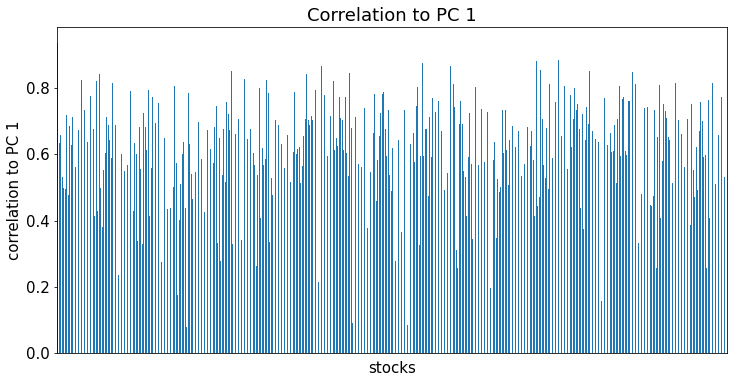

In [11]:
pca_wts = pd.DataFrame(pca.components_,columns=rets.columns)
#pca_wts.index = ['PC 1','PC 2: Slope','PC 3: Curvature','PCA 4','PCA 5','PCA 6','PCA 7']

pca_factors = rets @ pca_wts.T

allrets = pd.concat([retsSPY,rets],axis=1).dropna()

temp = pd.concat([pca_factors.iloc[:,0:3],allrets],axis=1)
rho = temp.corr()
fh = rho.iloc[3:,0].plot.bar()

fh.set_xticks([])#tick_params(bottom=False)
plt.xlabel('stocks')
plt.ylabel('correlation to PC 1')
plt.title('Correlation to PC 1')
plt.show()

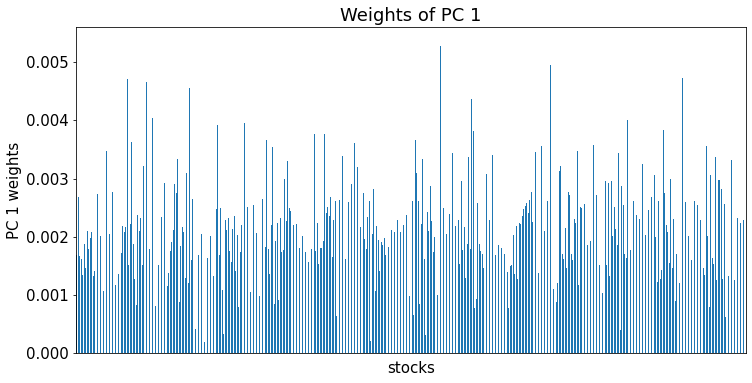

In [12]:
fh = (pca_wts.loc[0]/pca_wts.loc[0].sum()).plot.bar()
fh.set_xticks([])
plt.xlabel('stocks')
plt.ylabel('PC 1 weights')
plt.title('Weights of PC 1')
plt.show()

The second PC seems to be a long-short portfolio, loading on relative differences of stocks.

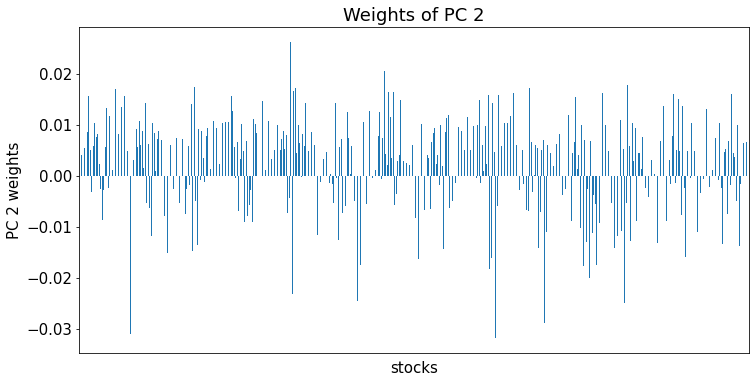

In [13]:
fh = (pca_wts.loc[1]/pca_wts.loc[1].sum()).plot.bar()
fh.set_xticks([])
plt.xlabel('stocks')
plt.ylabel('PC 2 weights')
plt.title('Weights of PC 2')
plt.show()

### 3.3

Correlation of SPY to the top 3 PC factors is below.

The correlation of PC 1 to SPY is over 90%. This supports the idea that movements in SPY drive much of the overall variation.

In [14]:
rho.loc[[0,1,2],'SPY'].to_frame().T.style.format('{:.1%}')

,0,1,2
SPY,93.7%,-24.6%,-13.7%


SPY's pairwise correlation to stocks is, (on average,) over 60%.

PC 1's pairwise correltion ot stocks is, (on average,) nearly the same.

In [15]:
pd.DataFrame([rho['SPY'].iloc[4:].mean(), rho[0].iloc[4:].mean()]).T.style.format('{:.1%}')

,0,1
0,60.6%,61.8%
